<!-- :Author: Arthur Goldberg <Arthur.Goldberg@mssm.edu> -->
<!-- :Date: 2020-07-13 -->
<!-- :Copyright: 2020, Karr Lab -->
<!-- :License: MIT -->
# DE-Sim tutorial

DE-Sim makes it easy to build and simulate discrete-event models.
This page introduces the basic concepts of discrete-event modeling and teaches you how to build and simulate discrete-event model with DE-Sim. 

## Installation
Use `pip` to install `de_sim`.

In [1]:
!pip install de_sim



ERROR: Error while checking for conflicts. Please file an issue on pip's issue tracker: https://github.com/pypa/pip/issues/new
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/pip/_vendor/pkg_resources/__init__.py", line 3021, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.7/site-packages/pip/_vendor/pkg_resources/__init__.py", line 2815, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/pip/_vendor/pkg_resources/__init__.py", line 3012, in _parsed_pkg_info
    return self._pkg_info
  File "/usr/local/lib/python3.7/site-packages/pip/_vendor/pkg_resources/__init__.py", line 2815, in __getattr__
    raise AttributeError(attr)
AttributeError: _pkg_info

During handling of the above exception, another exception occurred:

Traceback (most recent

## DE-Sim model of a one-dimensional random walk
An Object-oriented (OO) discrete-event simulation (DES) can be built and run in DE-Sim in three steps: define a message type; define a simulation class; and build and run a simulation.
We illustrate this process with a model of a 
[random walk on the integer number line](https://en.wikipedia.org/wiki/Random_walk#One-dimensional_random_walk).
To make its temporal behavior interesting we modify the traditional random walk by randomly selecting the time between steps.

### 1: Create event message types by subclassing `EventMessage`, a customized DE-Sim class.

DES models execute events at discrete instants of time.
Each event contains an event message that provides data needed by the simulation object that executes the event.
The random walk model sends events that contain the size of the random step.
`attributes` is a special attribute of an `EventMessage` that specifies a list of a message class' attributes.
`attributes` is optional.

Event message classes must be documented by docstrings.

In [8]:
import de_sim

class RandomStepMessage(de_sim.EventMessage):
    "An event message class that specifies a random step"
    attributes = ['step']

### 2: Define simulation object classes by subclassing `SimulationObject`.

As in an OO program, the classes used by a DES application encapsulate data and code that determine the application's behavior.
Subclasses of `SimulationObject`, called *simulation object classes*, are special classes that generate and handle simulation events.
Instantiated simulation objects are like threads, in that they are run by a simulation's scheduler and suspend execution when they have no work to do.
But DES simulation objects and threads are scheduled by different algorithms.
Whereas threads are scheduled whenever they have work to do,
a DES scheduler schedules simulation objects to ensure that events occur in simulation time order:

1. All events in a simulation are executed in non-decreasing time order. (Events with equal simulation times are scheduled by DE-Sim according to the tie-breaking rules discussed in the [Advanced DE-Sim notebook](https://sandbox.karrlab.org/notebooks/de_sim/2.%20DE-Sim%20advanced%2C%20simultaneous%20events.ipynb).) 

By guaranteeing this behavior, the DE-Sim scheduler ensures that causality relationships between events are respected.
This rule has two consequences:

1. All synchronization between simulation objects is controlled by the simulation times of events.
2. Each simulation object executes its events in increasing time order.
(If a simulation object receives multiple events at a given simulation time, then it executes *all* of the events together, as discussed in the [Advanced DE-Sim notebook](https://sandbox.karrlab.org/notebooks/de_sim/2.%20DE-Sim%20advanced%2C%20simultaneous%20events.ipynb).)

Below, we define a simulation class that models a random walk, and illustrates many of the key features of DE-Sim's `SimulationObject`.

In [23]:
import random

class RandomWalkSimulationObject(de_sim.SimulationObject):
    """ A one-dimensional random walk model, with random times between steps

    Attributes:
        name: the name of an instance of this object; each instance must have a unique name
        state: the current position; initialized to 0
        history: position as a function of time
    """

    def __init__(self, name):
        super().__init__(name)

    def schedule_next_step(self):
        """ Schedule the next event, a step that moves -1 or +1 with equal probability """
        step = random.choice([-1, +1])
        # the time between steps is randomly 1 or 2, with equal probability
        self.send_event(random.choice([1, 2]), self, RandomStepMessage(step))

    def init_before_run(self):
        """ Initialize before a simulation run; called by the simulator

        Schedule the first event
        """
        self.position = 0
        self.history = {'times': [0],
                        'positions': [0]}
        self.schedule_next_step()

    def handle_step_event(self, event):
        """ Handle a step event """
        # update the position and history
        step = event.message.step
        self.position += step
        self.history['times'].append(self.time)
        self.history['positions'].append(self.position)
        self.schedule_next_step()

    # event_handlers is a list of pairs that maps each event message type
    # received by this simulation object class to the method that handles
    # the event message class
    event_handlers = [(RandomStepMessage, handle_step_event)]

    # messages_sent registers all message types sent by this object
    messages_sent = [RandomStepMessage]

A subclass of `SimulationObject` contains special methods and attributes that define its simulation behavior.

* Special methods
  1. `init_before_run` (optional): just before a simulation run, after all simulation objects have been added to a `Simulator`, the simulator calls `init_before_run` in each simulation object. Simulation objects can send initial events and perform any other initialization in `init_before_run`. For example, in `RandomWalkSimulationObject`, the `init_before_run` method initializes the simulation object's position and history attributed, and schedules the object's first event, which carries a `RandomStepMessage` message. A simulation must send at least one initial event to initiate the simulation's execution.
  2. `send_event`: `send_event(delay, receiving_object, event_message)` schedules an event to occur `delay` time units in the future at simulation object `receiving_object`, which will execute a simulation event containing `event_message`. An event can be scheduled for any simulation object in a simulation, including the object scheduling the event, as shown in `RandomWalkSimulationObject`. `event_message` must be an instance of an `EventMessage`. 
  The event will be executed by an event handler in simulation object `receiving_object`, with a parameter that is set to a simulation event containing `event_message` at its scheduled simulation time. In this example all simulation events are scheduled to be executed by the object that creates the event, but most realistic simulations contain multiple simulation objects which schedule events for each other. 
  Object-oriented DES terminology also describes the event message as being sent by the sending object at the message's send time (the simulation time when the event is scheduled) and being received by the receiving object at the event's receive time (the simulation time when the event is executed).
  3. event handlers: an event handler is a method that handles a simulation event. Event handlers have the signature `event_handler(self, event)`, where `event` is a DE-Sim simulation event (`de_sim.Event`). A subclass of `SimulationObject` must define at least one event handler, like `handle_step_event` in the example above.
* Special attributes
  1. `event_handlers`: the attribute `event_handlers` must contain a list of pairs that maps each event message type received by a subclass of `SimulationObject` to the subclass' event handler which handles the event message type. In the example above, `event_handlers` associates `RandomStepMessage` event messages with the `handle_step_event` event handler. The DE-Sim simulator contains a scheduler that runs an object dispatch algorithm which executes an event by using the `event_handlers` attribute of the receiving object identified in the event to determine the object's method that will execute the event. It then dispatches execution to that method in the receiving object while passing the event as an argument.
  2. `messages_sent`: the types of messages sent by a subclass of `SimulationObject` must be listed in `messages_sent`. This is used to ensure that a simulation object doesn't send messages of the wrong class.
  3. `time`: `time` is a read-only simulation object attribute that always equals the current simulation time. `RandomWalkSimulationObject` uses `time` to saves its value when recording the history history.

### 3: Execute a simulation application by creating a `Simulator`, instantiating and adding the application's simulation objects, and running the simulation.

The `Simulator` class simulates models.
Its `add_object` method adds a simulation object to the simulator.
The `initialize` method must be called before a simulation starts.
Finally, `run` simulates the model. It takes the maximum time to which the simulation can execute. `run` also takes many other arguments, as described in the DE-Sim API documentation.

Random 10 step walk:
   0     0
   1     1
   2     2
   3     3
   5     2
   6     1
   8     2
   9     3


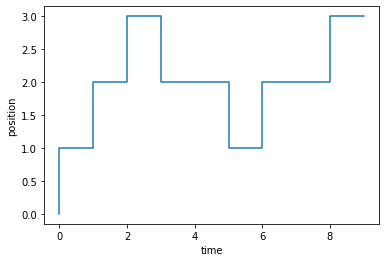

In [28]:
# create a simulator
simulator = de_sim.Simulator()

# create a simulation object and add it to the simulation
random_walk_sim_obj = RandomWalkSimulationObject('rand_walk')
simulator.add_object(random_walk_sim_obj)

# initialize the simulation, and send initial event messages
simulator.initialize()

# run the simulation until time 10
max_time = 10
simulator.run(max_time)

# print the random walk
print(f'{max_time} time unit random walk:')
for time, pos in zip(random_walk_sim_obj.history['times'],
                     random_walk_sim_obj.history['positions']):
    print(f"{time:4.0f}{pos:>6}")

# plot the random walk as a step function
%matplotlib inline
import matplotlib.pyplot as plt
plt.step(random_walk_sim_obj.history['times'], random_walk_sim_obj.history['positions'])
plt.xlabel('time')
plt.ylabel('position')
plt.show()

## DE-Sim example with multiple object instances

This section presents an implementation of the parallel hold (PHOLD) model, which is frequently used to benchmark parallel DES (PDES) simulators.
We implement PHOLD as a DE-Sim model and use it to illustrate these features:

* Use multiple `EventMessage` types
* Run multiple instances of a simulation object type
* Show simulation objects scheduling events for each other

In [27]:
""" Parallel hold (PHOLD) model commonly used to benchmark parallel discrete-event simulators :cite:`fujimoto1990performance`.
"""
import random

class MessageSentToSelf(de_sim.EventMessage):
    "A message that's sent to self"

class MessageSentToOtherObject(de_sim.EventMessage):
    "A message that's sent to another PHold simulation object"

class InitMsg(de_sim.EventMessage):
    'initialization message'

MESSAGE_TYPES = [MessageSentToSelf, MessageSentToOtherObject, InitMsg]


class PholdSimulationObject(de_sim.SimulationObject):
    """ Run a PHOLD simulation

    Attributes:
        args: a :obj:`Namespace` that defines:
            `num_phold_objects`: the number of PHOLD objects to run
            `frac_self_events`: the fraction of events sent to `self`
            `time_max`: the end time for the simulation
    """
    def __init__(self, name, args):
        self.args = args
        super().__init__(name)

    def init_before_run(self):
        self.send_event(random.expovariate(1.0), self, InitMsg())

    @staticmethod
    def record_event_header():
        print('\t'.join(('Sender',
                         'Send',
                         "Receivr",
                         'Event',
                         'Message type')))
        print('\t'.join(('', 'time', '', 'time', '')))
        
    def record_event(self, event):
        record_format = '{}\t{:.2f}\t{}\t{:.2f}\t{}'
        print(record_format.format(event.sending_object.name,
                                   event.creation_time,
                                   event.receiving_object.name,
                                   self.time,
                                   type(event.message).__name__))

    def handle_simulation_event(self, event):
        """ Handle a simulation event """
        # Record this event
        self.record_event(event)
        # Schedule an event
        if random.random() < self.args.frac_self_events or \
            self.args.num_phold_objects == 1:
            receiver = self
        else:
            # Send the event to another randomly selected object
            # Pick an object index in [0, num_phold-2], and increment if self or greater
            obj_index = random.randrange(self.args.num_phold_objects - 1)
            if int(self.name) <= obj_index:
                obj_index += 1
            receiver = self.simulator.simulation_objects[str(obj_index)]

        if receiver == self:
            message_type = MessageSentToSelf
        else:
            message_type = MessageSentToOtherObject
        self.send_event(random.expovariate(1.0), receiver, message_type())

    event_handlers = [(sim_msg_type, 'handle_simulation_event') \
                      for sim_msg_type in MESSAGE_TYPES]

    # register the message types sent
    messages_sent = MESSAGE_TYPES


def create_and_run(args):

    # create a simulator
    simulator = de_sim.Simulator()

    # create simulation objects, and send each one an initial event message to self
    for obj_id in range(args.num_phold_objects):
        phold_obj = PholdSimulationObject(str(obj_id), args)
        simulator.add_object(phold_obj)

    # run the simulation
    simulator.initialize()
    PholdSimulationObject.record_event_header()
    event_num = simulator.simulate(args.time_max).num_events
    print("Executed {} events.\n".format(event_num))

The PHOLD model runs multiple instances of `PholdSimulationObject`.
To simplify the example, each object's name is the string representation of its integer index.
`create_and_run` creates the objects and adds them to the simulator.

Each `PholdSimulationObject` object is initialized with `args`, a namespace object that defines two attributes used by all objects:

* `args.num_phold_objects`: the number of PHOLD objects running
* `args.frac_self_events`: the fraction of events sent to self

At time 0, each PHOLD object schedules an `InitMsg` event for itself that occurs after a random exponential time delay with mean = 1.0.

The `handle_simulation_event` method handles all events.
Each event schedules one more event.
A PHOLD object uses a U(0,1) random value to decide whether to schedule the event for itself (with probability `args.frac_self_events`) or for another PHOLD object.

If the event is scheduled for another PHOLD object, this line obtains a reference to the object: 

    receiver = self.simulator.simulation_objects[str(obj_index)]

It uses the attribute `self.simulator`, which always references the simulator that is running, and `self.simulator.simulation_objects`, a dictionary that maps simulation object names to simulation object instances.

The prediction generated by a simulation can be saved in many ways. This example simply prints them.

Each event is printed by `record_event`.
It accesses the DE-Sim `Event` object that is passed to all event handlers.
`de_sim.event.Event` contains five useful fields:

* `sending_object`: the object that created and sent the event
* `creation_time`: the simulation time when the event was created (a.k.a. its *send time*)
* `receiving_object`: the object that received the event
* `event_time`: the simulation time when the event must execute (a.k.a. its *receive time*)
* `message`: the `EventMessage` carried by the event

However, rather than use the event's `event_time`, `record_event` uses `self.time` to report the simulation time when the event is being executed, as they are always equal.

In [6]:
from argparse import Namespace
args = Namespace(time_max=4,
                 frac_self_events=0.3,
                 num_phold_objects=6)
create_and_run(args)

Sender	Send	Receivr	Event	Message type
	time		time	
3	0.00	3	0.39	InitMsg
3	0.39	3	0.41	MessageSentToSelf
0	0.00	0	0.48	InitMsg
3	0.41	4	0.59	MessageSentToOtherObject
1	0.00	1	0.81	InitMsg
4	0.59	0	1.38	MessageSentToOtherObject
4	0.00	4	1.57	InitMsg
4	1.57	2	1.61	MessageSentToOtherObject
1	0.81	3	1.86	MessageSentToOtherObject
5	0.00	5	2.13	InitMsg
2	1.61	3	2.44	MessageSentToOtherObject
0	0.48	2	2.69	MessageSentToOtherObject
5	2.13	1	2.73	MessageSentToOtherObject
3	2.44	0	2.78	MessageSentToOtherObject
2	0.00	2	2.81	InitMsg
1	2.73	5	3.03	MessageSentToOtherObject
2	2.81	1	3.03	MessageSentToOtherObject
5	3.03	0	3.13	MessageSentToOtherObject
0	3.13	4	3.18	MessageSentToOtherObject
4	3.18	1	3.20	MessageSentToOtherObject
0	2.78	5	3.21	MessageSentToOtherObject
1	3.03	3	3.32	MessageSentToOtherObject
3	3.32	1	3.34	MessageSentToOtherObject
1	3.34	2	3.35	MessageSentToOtherObject
3	1.86	0	3.48	MessageSentToOtherObject
0	1.38	0	3.55	MessageSentToSelf
5	3.21	5	3.99	MessageSentToSelf
Executed 27 events